In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
PARQUET_PATH = "../../04_merged/all_merged.parquet"

# Required fields 
TIME_KEYS   = ["donor", "year", ]
CLONE_KEYS  = ["v_gene", "j_gene", "cdr3_aa"]
NEEDED_COLS = CLONE_KEYS + TIME_KEYS + ["isotype"] +['cdr3_length'] + ['sequence','productive'] + ['replicate'] + ['v_mutation_count'] + ['v_mutation_count_aa']

# Memory filter
MEMORY_ISOTYPES = ["IgG1","IgG2","IgG3","IgG4","IgA1","IgA2",]

# Other params
CLONOTYPE_KEYS = ['v_gene', 'j_gene', 'cdr3_aa'] 

In [3]:
# Use lazy scan for scale
lf = pl.scan_parquet(PARQUET_PATH).select(NEEDED_COLS)

# filter on productive
lf = lf.filter(
    pl.col('productive')
)

# Compute Clonotypes
lf = lf.with_columns(
    (pl.col('v_gene') + pl.lit('|') + pl.col('j_gene') + pl.lit('|') + pl.col('cdr3_aa')).alias('clonotype')
)

# Group timepoints
lf = lf.with_columns(
    pl.when(pl.col('year').is_in(["2020", "2021"]))
    .then(pl.lit('Late'))
    .otherwise(pl.lit('Early'))
    .alias('timepoint')
)

# Count timepoints and donors per clonotype
lf = lf.with_columns(
    (pl.col('timepoint').n_unique().over('clonotype').alias('n_timepoints')),
    (pl.col('donor').n_unique().over('clonotype').alias('n_donors')),
)

# Add biological replicate info
bioreps = {1:1,2:2,3:3,4:4,5:5,6:6,7:1,8:2,9:3,10:4,11:5,12:6,13:1,14:2,15:3,16:4,17:5,18:6}
mini_df = pl.LazyFrame({"replicate":k,"biorep":v} for k,v in bioreps.items())
lf = lf.join(mini_df, on='replicate', how='full', )

In [4]:
# Collect data once
df = lf.collect()

In [5]:
# public clonotypes in earlier timpoints (2016)
df.filter(
    (pl.col('timepoint') == 'Early')
    & (pl.col('n_donors') == 2)
).select('clonotype').n_unique()

31820

In [6]:
# public clonotypes in later timpoints (2020 & 2021)
df.filter(
    (pl.col('timepoint') == 'Late')
    & (pl.col('n_donors') == 2)
).select('clonotype').n_unique()

22447

#### CDR3 length

In [7]:
p = Counter(df.filter(pl.col('n_donors')>1).select('cdr3_length')['cdr3_length'])

In [8]:
_np = Counter(df.filter(pl.col('n_donors')==1).select('cdr3_length')['cdr3_length'])

In [9]:
len_data={'public': p, 'private': _np}

In [10]:
len_df=pd.DataFrame(len_data).fillna(0)
len_df=len_df/len_df.sum()

In [11]:
len_df.sort_index(inplace=True)

In [12]:
def step(x, ys, colors=None, labels=None, figfile=None, figsize=(8, 3), color=[0.3] * 3,
                ylim=None, xlim=None, xtick_interval=1, linewidth=1.25, xlabel=None, show_legend=False):
    
    sns.set_style('white')

    if xlim is None:
        xlim = (-0.5, len(xs))
    if ylim is None:
        ylim = (0, 1.1 * max([max(y) for y in ys]))
    if colors is None:
        colors = sns.color_palette('muted', len(ys))
    if labels is None:
        labels = [None] * len(ys)

    plt.figure(figsize=figsize)
    for y, color, label in zip(ys, colors, labels):
        plot = plt.step(x, y, where='mid', color=color, linewidth=linewidth, label=label)
        plt.fill_between(x, y, step='mid', color=color, alpha=0.1)

    ax = plt.gca()
    ax.set_ylabel('Frequency', size=14, labelpad=8)
    if xlabel is not None:
        ax.set_xlabel(xlabel, size=14, labelpad=8)
    plt.xticks(x[::xtick_interval], x[::xtick_interval], size='medium')
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if show_legend:
        plt.legend(fontsize=12, handlelength=1)
    
    plt.tight_layout()
    if figfile is not None:
        plt.savefig(figfile)
    else:
        plt.show()

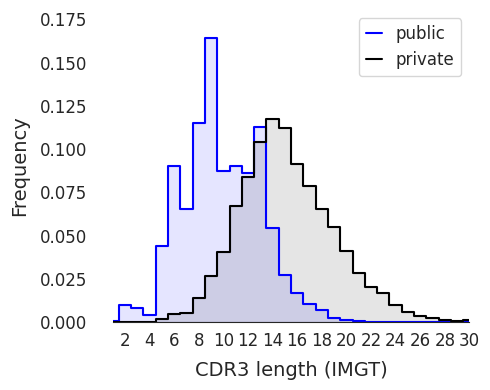

In [13]:
x = len_df.index.values
labels = len_df.columns.values
ys = [list(len_df[l]) for l in labels]
colors = ['b', 'k']

step(x, ys, colors=colors, labels=labels, xlim=[1, 30], xtick_interval=2,
     figsize=(5, 4), linewidth=1.5, xlabel='CDR3 length (IMGT)', show_legend=True,
      figfile='./3c_public_CDR3len_step-plot.svg'
    )

#### IgG frequency

In [14]:
NEEDED = ["replicate", "n_donors", "clonotype", "isotype"]

lz_small = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns]))

result = (
    lz_small
    .group_by(["replicate", "n_donors"])
    .agg(
        total = pl.col("clonotype").n_unique(),
        IgM   = pl.col("clonotype")
                 .filter(pl.col("isotype").str.starts_with("IgM"))
                 .n_unique(),
        IgG   = pl.col("clonotype")
                 .filter(pl.col("isotype").str.starts_with("IgG"))
                 .n_unique(),
    )
    .with_columns(
        IgM_freq = (pl.col("IgM") / pl.col("total")).fill_null(0.0),
        IgG_freq = (pl.col("IgG") / pl.col("total")).fill_null(0.0),
    )
    .select("replicate","n_donors","total","IgM","IgM_freq","IgG","IgG_freq")
)

In [15]:
r = result.collect()

In [16]:
np_freq = r.filter(pl.col('n_donors') == 1).select(['IgG_freq'])
p_freq = r.filter(pl.col('n_donors') == 2).select(['IgG_freq'])

In [17]:
data_dict = {'public': p_freq["IgG_freq"].to_list(), 'private': np_freq["IgG_freq"].to_list()}

In [18]:
color_dict={'public': 'blue', 'private': 'grey'}

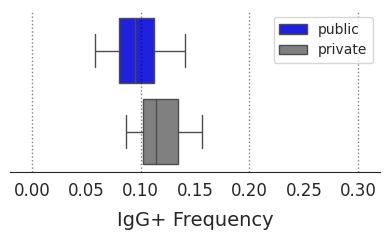

In [19]:
sns.set_style('white')
plt.figure(figsize=(4, 2.5))
ax = plt.gca()
sns.boxplot(data=data_dict,
            palette=['blue','grey'],
             orient='h', ax=ax, legend=True, )
ax.set_xlim([-0.02, 0.32])
ax.set_xlabel('IgG+ Frequency', size=14, labelpad=8)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.set_yticklabels("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for x in np.arange(0, 0.4, 0.1):
    ls = ':'
    lw = 1
    alpha=0.5
    plt.axvline(x=x, linewidth=lw, color='k', linestyle=ls, alpha=alpha)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./3d_igg_frequency_public.svg', dpi=1200)
plt.show()
plt.close()

#### Mutations

In [20]:
NEEDED = ["replicate", "n_donors", "v_mutation_count"]

lz_small = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns]))

mut_stats = (
    lz_small
    .group_by(["replicate", "n_donors"])
    .agg(
        mut_median = pl.col("v_mutation_count").median(),
        mut_mean   = pl.col("v_mutation_count").mean(),
        mut_std    = pl.col("v_mutation_count").std(ddof=1),
        n = pl.len(),
    )
    .select("replicate","n_donors","mut_median","mut_mean","mut_std","n")
    .collect()
)

np_vals = (
    mut_stats
    .filter(pl.col("n_donors") == 1)
    .get_column("mut_mean")
    .to_list()
)
p_vals = (
    mut_stats
    .filter(pl.col("n_donors") == 2)
    .get_column("mut_mean")
    .to_list()
)

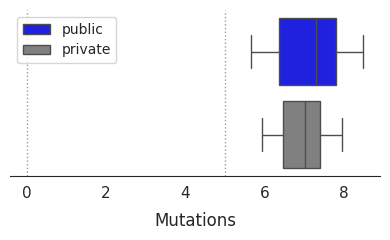

In [21]:
data_dict = {"public": p_vals, "private": np_vals}

sns.set_style('white')
plt.figure(figsize=(4, 2.5))
ax = plt.gca()
sns.boxplot(
    data=data_dict,
    palette=['blue', 'grey'],
    orient='h',
    ax=ax, legend=True
)

ax.set_xlabel('Mutations', size=12, labelpad=8)
ax.set_ylabel('', size=0)
ax.tick_params(axis='x', labelsize=11)
ax.set_yticklabels("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for x in np.arange(0, max(p_vals + np_vals + [0]) * 1.1, 5):
    plt.axvline(x=x, linewidth=1, color='k', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('./3e_public_v_mutation_count_box.svg', dpi=1200)
plt.show()
plt.close()

#### Freq of clonotypes in >1 bioreplicate

In [22]:
NEEDED = ["donor", "biorep", "clonotype", "n_donors"]
lz = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns]))

per_clono_labels = (
    lz.group_by(["donor", "clonotype"])
      .agg(
          publicness = pl.col("n_donors").max(),
          n_reps_present = pl.col("biorep").n_unique(),
      )
)

present_rc = (
    lz.select("donor", "biorep", "clonotype").unique()
)

annot = (
    present_rc
    .join(per_clono_labels, on=["donor","clonotype"], how="inner")
)

per_rep_freq = (
    annot
    .group_by(["donor", "biorep", "publicness"])
    .agg(
        total = pl.len(),
        multi = (pl.col("n_reps_present") > 1).cast(pl.Int64).sum(),
    )
    .with_columns(freq = (pl.col("multi") / pl.col("total")).fill_null(0.0).cast(pl.Float64))
    .collect()
)

per_rep_plot = (
    per_rep_freq
    .with_columns(
        fraction = pl.when(pl.col("publicness")==2).then(pl.lit("public"))
                     .otherwise(pl.lit("private"))
    )
    .select("donor","biorep","fraction","freq")
)


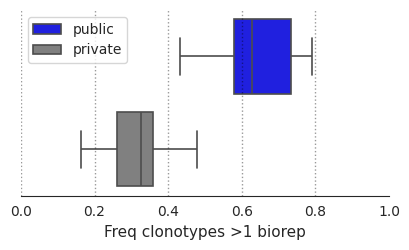

In [23]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4.2, 2.6))
sns.boxplot(
    data=per_rep_plot.sort(pl.col('fraction'), descending=True).to_pandas(),
    x="freq", y="fraction", hue='fraction',
    palette=["blue","grey"], orient="h", ax=ax, linewidth=1.2, 
)
ax.set_xlabel("Freq clonotypes >1 biorep", size=11)
ax.set_ylabel("")
ax.set_yticklabels("")
ax.set_xlim(0, 1)
ax.tick_params(axis="y", length=0)
for s in ("top","right","left"):
    ax.spines[s].set_visible(False)

for x in np.arange(0, 1, 0.2):
    plt.axvline(x=x, linewidth=1, color='k', linestyle=':', alpha=0.4)

plt.legend(labels=['public','private'], loc='upper left')
plt.tight_layout()
plt.savefig('./3f_public_freq_per_biorep.svg', dpi=1200)
plt.show()

#### WebLogos

In [49]:
%pip install weblogo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.7/571.7 kB 59.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
from weblogo import read_seq_data, LogoData, LogoOptions, LogoFormat, eps_formatter
from weblogo.colorscheme import ColorScheme, IndexColor, SymbolColor

In [46]:
public = df.filter(pl.col('n_donors')>1).select('cdr3_aa')
private = df.filter(pl.col('n_donors')==1).select('cdr3_aa')

In [47]:
with open('./public_cdr3s','w') as f:
    for i, s in enumerate(public["cdr3_aa"].to_list()):
        if s:
            if len(s) == 13:
                f.write(f">{i}\n")
                f.write(f"{s}\n")

In [48]:
with open('./non_public_cdr3s','w') as f:
    for i, s in enumerate(private["cdr3_aa"].to_list()):
        if s:
            if len(s) == 13:
                f.write(f">{i}\n")
                f.write(f"{s}\n")

In [49]:
opts_kwargs = {'unit_name': 'probability',
               'show_xaxis': False,
               'show_yaxis': False,
               'show_fineprint': False,
               'stack_aspect_ratio': 3}
rules_13AA = [IndexColor(range(3), '#C0C0C0'),
              IndexColor(range(10, 13), '#C0C0C0'),
              SymbolColor("GSTYC", "green", "polar"),
              SymbolColor("NQ", "purple", "neutral"),
              SymbolColor("KRH", "blue", "basic"),
              SymbolColor("DE", "red", "acidic"),
              SymbolColor("PAWFLIMV", "black", "hydrophobic")]

colorscheme_13AA = ColorScheme(rules_13AA)

options = LogoOptions(**opts_kwargs)
options.color_scheme = colorscheme_13AA

In [50]:
# Public fraction
with open('./public_cdr3s') as f:
    seqs = read_seq_data(f)
    data = LogoData.from_seqs(seqs)
    fmt = LogoFormat(data, options)
    eps = eps_formatter(data, fmt)
    with open('./3f_public_13AA_weblogo.eps', 'wb') as eps_file:
            eps_file.write(eps)

In [51]:
# Private fraction
with open('./non_public_cdr3s') as f:
    seqs = read_seq_data(f)
    data = LogoData.from_seqs(seqs)
    fmt = LogoFormat(data, options)
    eps = eps_formatter(data, fmt)
    with open('./3f_non_public_13AA_weblogo.eps', 'wb') as eps_file:
            eps_file.write(eps)